### Librerie

In [1]:
import numpy as np
import pandas as pd
from keras import backend as K
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from collections import defaultdict
from yellowbrick.contrib.classifier import DecisionViz
from sklearn.decomposition import PCA
from itertools import product
from yellowbrick.datasets import load_credit
from yellowbrick.features import PCA as yPCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score 
from scikitplot.metrics import plot_precision_recall, plot_roc, plot_cumulative_gain, plot_lift_curve
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.model_selection import KFold
from sklearn import tree
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score, classification_report

Using TensorFlow backend.
c:\users\matte\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\users\matte\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\users\matte\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16

In [2]:
# Dataset con attributi originali
df = pd.read_csv("dataset_All_normalized.csv")
class_name = 'Occupancy'

In [3]:
df.head()

,Temperature,Light,CO2,HumidityRatio,Day,Afternoon,Evening,Night,Weekday,Weekend,Occupancy
0,0.869029,0.603964,0.208231,0.549737,0,1,0,0,1,0,1
1,0.872357,0.596946,0.215163,0.551972,0,1,0,0,1,0,1
2,0.874576,0.591029,0.220898,0.549997,0,1,0,0,1,0,1
3,0.873190,0.509582,0.224045,0.544374,0,1,0,0,1,0,1
4,0.879014,0.504267,0.226675,0.550376,0,1,0,0,1,0,1


In [4]:
attributes = [col for col in df.columns if col != class_name]
X = df[attributes].values
y = df[class_name]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1000, stratify=y)

In [5]:
def result_pred(y_true, y_pred):
    print("**** Matrice di Confusione *****")
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    print(' True negative: %d False negative: %d' % (tn, fn))
    print(' True positive: %d False positive: %d' % (tp, fp))
    print("____________________________________________")

    # Calcolo dell'accuracy
    print("***** Calcolo dell'accuracy *****")
    accuracy = accuracy_score(y_true, y_pred)    
    print('Frazione di campioni correttamente correlati: %0.4f' % accuracy)
    accuracy = accuracy_score(y_true, y_pred, False)
    print("Numero di campioni correttamente correlati: ", accuracy)    
    print("____________________________________________")

    # Calcolo della precision
    print("**** Calcolo della precisione *****")
    #Percentuale di classificazioni positive che sono corrette
    #se dico "positivo" dico giusto?
    precision = precision_score(y_true, y_pred)
    print('Percentuale di classificazioni positive che sono corrette: %0.4f' % precision)   
    print("____________________________________________")    

    # Calcolo della recall
    print("**** Calcolo della recall (sensitivity) *****")
    recall = recall_score(y_true, y_pred)
    print('Percentuale di elementi positivi del testing set che sono stati classificati come positivi: %0.4f' % recall)
    print("____________________________________________")    

    # Calcolo della specificity
    print("**** Calcolo della specificity *****")
    specificity = tn / (tn+fp)
    print('Percentuale di elementi negativi del testing set che sono stati classificati come negativi: %0.4f' % specificity)
    print("____________________________________________")   
    
    # Calcolo dell'F1 score
    print("**** Calcolo della F1 score *****")
    f1 = f1_score(y_true, y_pred)
    #Il punteggio F1 può essere interpretato come una media ponderata della precisione e della recall, 
    #in cui un punteggio F1 raggiunge il suo valore migliore a 1 e il punteggio peggiore a 0.
    print('F1 scores: %0.4f' % f1)
    print("____________________________________________")   
    
    # Stampiamo le stesse statistiche dalla funzione report
    print(classification_report(y_test, y_pred))
    
    print("Con le tecniche viste finora non viene fornita nessuna informazione sulla “gravità” degli errori (“errore lieve” oppure “errore grave)")
    print("per questo si usano la curva CMC, la curva ROC")


In [32]:
def plot_res(y_pred, y_score, y_test):
    #ROC CURVE: implementazione legata esclusivamente all'attività di classificazione binaria
    #false positive rate, true positive rate
    print("****** ROC CURVE + AUC?: passo passo *******")
    fprate, tprate, threashold = roc_curve(y_test, y_score[:, 1])
    auc_score = auc(fprate, tprate)
    plt.plot(fprate, tprate, color='darkorange', lw=3, label='$AUC_0$ = %.3f' % (auc_score))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.title('ROC curve', fontsize=16)
    plt.legend(loc="lower right", fontsize=14, frameon=False)
    plt.tick_params(axis='both', which='major', labelsize=16)
    plt.show()

    print("____________________________________")
    print("****** VALORE DI AUC *******")    
    print(roc_auc_score(y_test, y_score[:,1]))    
    
    print("____________________________________")
    print("****** ROC CURVE: con metodo diretto *******")
    plot_roc(y_test, y_score)
    plt.show()
    
    print("____________________________________")
    print("****** Precision recall: con metodo diretto *******")
    plot_precision_recall(y_test, y_score)
    plt.show()
    

    print("____________________________________")
    print("****** Cumulative gain: con metodo diretto *******")
    plot_cumulative_gain(y_test, y_score)
    plt.show()
    
    
    print("____________________________________")
    print("****** Lift curve: con metodo diretto *******")    
    plot_lift_curve(y_test, y_score)
    plt.show()

In [7]:
def f1(y_true, y_pred):
    prec = precision(y_true, y_pred)
    rec = recall(y_true, y_pred)
    
    return 2*((prec*rec)/(prec+rec+K.epsilon()))
def recall(y_true, y_pred):
    """Recall metric.

    Only computes a batch-wise average of recall.

    Computes the recall, a metric for multi-label classification of
    how many relevant items are selected.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall
def precision(y_true, y_pred):
    """Precision metric.

    Only computes a batch-wise average of precision.

    Computes the precision, a metric for multi-label classification of
    how many selected items are relevant.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

# -------------------------- Deep Neural Network -----------------------------------

In [8]:
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.optimizers import SGD
from sklearn.model_selection import GridSearchCV

In [9]:
# https://machinelearningmastery.com/tutorial-first-neural-network-python-keras/
# I modelli in keras sono definiti come una sequenza di livelli. 
# 1) Quindi creiamo un "Sequential model" e aggiungiamo i livelli uno alla volta
# 2) Nel primo livello dobbiamo inserire il numero di feature. Quindi assegnamo all'argomento "input_dim" 
# il numero di features da utilizzare
# Come configurare il numero di livelli e nodi in una NN
# https://machinelearningmastery.com/how-to-configure-the-number-of-layers-and-nodes-in-a-neural-network/
# 3) Utilizzamo una rete fully-connected, usando la classe "Dense"
# 4) Possiamo specificare il numero di neuroni o nodi nel livello con il primo argomento e specificare l'activation function
# La sigmoid sull'utimo livello ci assicura che l'output sia compreso tra 0 e 1
# 5) Durante la compilazione è necessario specificare alcune proprietà aggiuntive richieste per l'addestramento della rete
# Specifichiamo la funzione di perdita (loss) da utilizzare per valutare l'insieme di pesi
# "binary_crossentropy" è una funzione loss per classificazione binaria
# Come scegliere le loss functions: https://machinelearningmastery.com/how-to-choose-loss-functions-when-training-deep-learning-neural-networks/
# 6) Il training del modello si svolge su epoche e ogni epoca è suddivisa in lotti (batch):
# - Epoche: passa attraverso tutte le righe del training set
# - Batch: uno o più campioni considerati dal modello in un'epoca priam dell'aggiornamento dei pesi
# Differenza tra Epochs e Batch: https://machinelearningmastery.com/difference-between-a-batch-and-an-epoch/


In [10]:
from keras.regularizers import l2


In [11]:
def build_model_1(optimizer='adagrad'):
    n_feature = X_train.shape[1]
    model = Sequential()
    model.add(Dense(32, input_dim=n_feature, activation='tanh'))
    model.add(Dense(32, activation='tanh'))
    model.add(Dense(32, activation='tanh'))
    model.add(Dense(32, activation='tanh'))
    model.add(Dense(32, activation='tanh'))
    model.add(Dense(32, activation='tanh'))
    model.add(Dense(32, activation='tanh'))
    model.add(Dense(32, activation='tanh'))
    # Linear
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=[f1])
    return model

In [12]:
def build_model_2(optimizer='adam'):
    n_feature = X_train.shape[1]
    model = Sequential()
    model.add(Dense(128, input_dim=n_feature, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(32, activation='relu'))
    # Linear
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=[f1])
    return model

In [13]:
model1 = build_model_1()
history1 = model1.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=30, batch_size=10).history

model2 = build_model_2()
history2 = model2.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=30, batch_size=50).history


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 14392 samples, validate on 6168 samples
Epoch 1/30
14392/14392 [==============================] - 4s 274us/step - loss: 0.0508 - f1: 0.9031 - val_loss: 0.0435 - val_f1: 0.9103
Epoch 2/30
14392/14392 [==============================] - 3s 210us/step - loss: 0.0427 - f1: 0.8967 - val_loss: 0.0422 - val_f1: 0.9091
Epoch 3/30
14392/14392 [==============================] - 3s 190us/step - loss: 0.0419 - f1: 0.9095 - val_loss: 0.0431 - val_f1: 0.9109
Epoch 4/30
14392/14392 [==============================] - 3s 204us/step - loss: 0.0412 - f1: 0.9035 - val_loss: 0.0402 - val_f1: 0.9107
Epoch 5/30
14392/14392 [==============================] - 3s 194us/step - loss: 0.0406 - f1: 0.9039 - val_loss: 0.0396 - val_f1: 0.9109
Epoch 6/30
14392/14392 [==============================] - 3s 192us/step - loss: 0.0407 - f1: 0.9105 - val_loss: 0.0398 - val_f1: 0.9109
Epoch 7/30
1439

Epoch 26/30
14392/14392 [==============================] - 1s 48us/step - loss: 0.0361 - f1: 0.9797 - val_loss: 0.0336 - val_f1: 0.9783
Epoch 27/30
14392/14392 [==============================] - 1s 47us/step - loss: 0.0358 - f1: 0.9792 - val_loss: 0.0335 - val_f1: 0.9775
Epoch 28/30
14392/14392 [==============================] - 1s 46us/step - loss: 0.0358 - f1: 0.9794 - val_loss: 0.0326 - val_f1: 0.9778
Epoch 29/30
14392/14392 [==============================] - 1s 46us/step - loss: 0.0356 - f1: 0.9796 - val_loss: 0.0349 - val_f1: 0.9784
Epoch 30/30
14392/14392 [==============================] - 1s 47us/step - loss: 0.0352 - f1: 0.9783 - val_loss: 0.0315 - val_f1: 0.9774


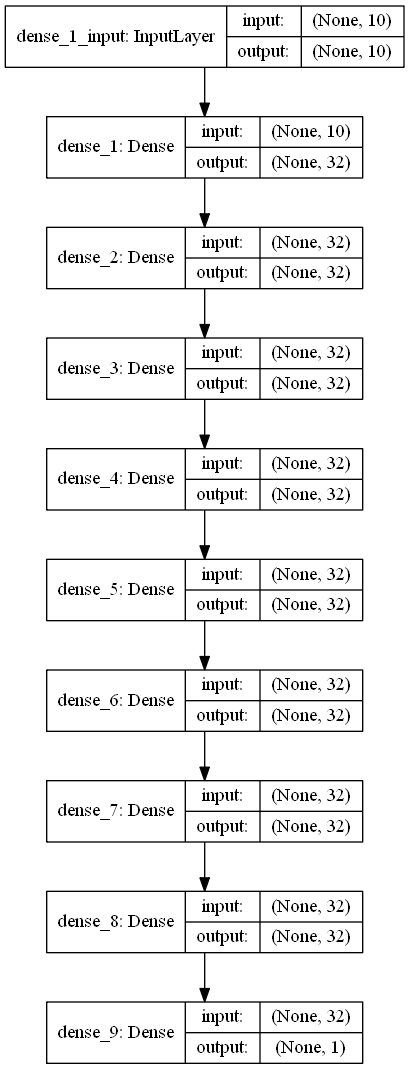

In [15]:
from keras.utils.vis_utils import plot_model
plot_model(model1, to_file='model1.png', show_shapes=True, show_layer_names=True)


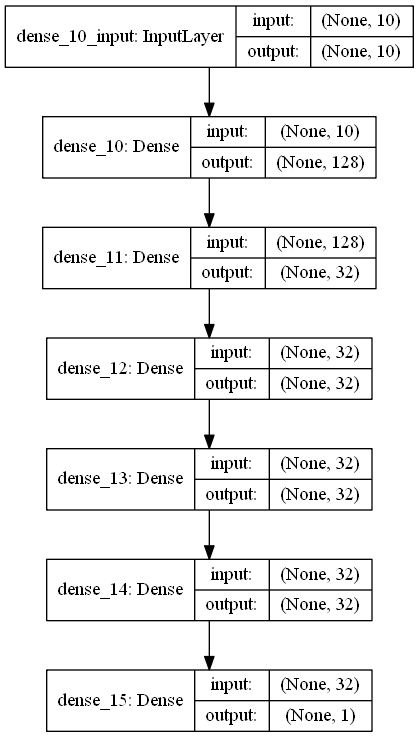

In [16]:
plot_model(model2, to_file='model2.png', show_shapes=True, show_layer_names=True)

# GridSearch

In [68]:
k_fold = StratifiedKFold(n_splits=4, random_state=42)
# create model
model = KerasClassifier(build_fn=build_model_1, epochs=30, batch_size=10, verbose=0)
# define the grid search parameters
optimizer = ['SGD', 'Adagrad', 'Adam']
param_grid = dict(optimizer=optimizer)
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=k_fold)
grid_result = grid.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=30, batch_size=10)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    
    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()
    print("**** Matrice di Confusione *****")
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    print(' True negative: %d False negative: %d' % (tn, fn))
    print(' True positive: %d False positive: %d' % (tp, fp))
    print("____________________________________________")

c:\users\matte\appdata\local\programs\python\python37\lib\site-packages\sklearn\model_selection\_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


KeyboardInterrupt: 

In [60]:
# Interpretare i grafici
#https://machinelearningmastery.com/learning-curves-for-diagnosing-machine-learning-model-performance/

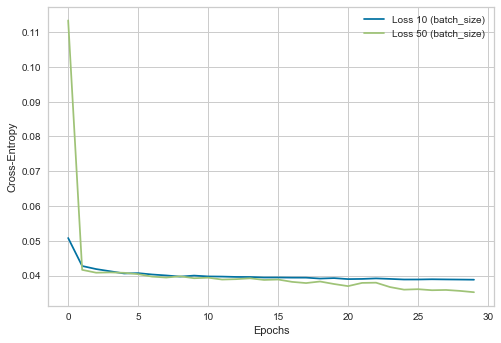

In [48]:
plt.plot(history1['loss'], label='Loss 10 (batch_size)')
plt.plot(history2['loss'], label='Loss 50 (batch_size)')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy')
plt.legend()
plt.show()

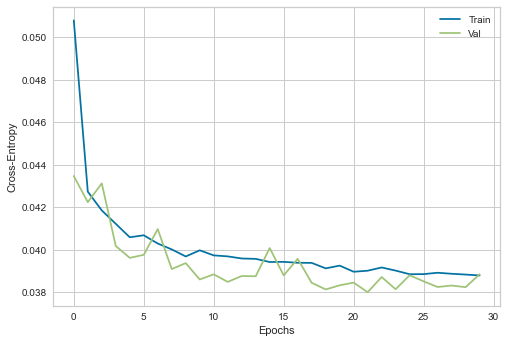

In [18]:
plt.plot(history1['loss'], label='Train')
plt.plot(history1['val_loss'], label='Val')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy')
plt.legend()
plt.show()

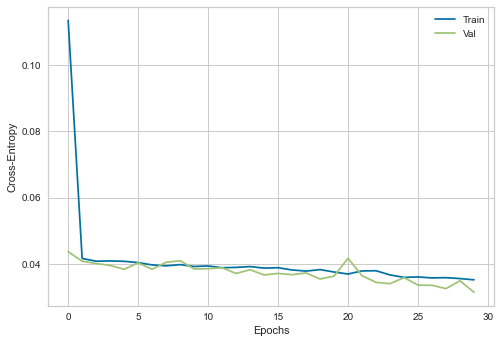

In [19]:
plt.plot(history2['loss'], label='Train')
plt.plot(history2['val_loss'], label='Val')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy')
plt.legend()
plt.show()

6168/6168 [==============================] - 0s 35us/step
Loss 0.038851, Accuracy 0.978759
Loss 0.031467, Accuracy 0.977390


# Valutazione dei modelli

In [34]:
test_loss_1, test_acc_1 = model1.evaluate(X_test, y_test)
test_loss_2, test_acc_2 = model2.evaluate(X_test, y_test)

print('Loss %f, Accuracy %f' % (test_loss_1, test_acc_1))
print('Loss %f, Accuracy %f' % (test_loss_2, test_acc_2))

6168/6168 [==============================] - 0s 29us/step
Loss 0.038851, Accuracy 0.978759
Loss 0.031467, Accuracy 0.977390


In [38]:
y_pred = model1.predict_classes(X_test)
result_pred(y_test, y_pred)
y_score = model1.predict_proba(X_test)
#plot_res(y_pred, y_score, y_test)

y_pred = model2.predict_classes(X_test)
result_pred(y_test, y_pred)
y_score = model2.predict_proba(X_test)
#plot_res(y_pred, y_score, y_test)

**** Matrice di Confusione *****
 True negative: 4682 False negative: 0
 True positive: 1425 False positive: 61
____________________________________________
***** Calcolo dell'accuracy *****
Frazione di campioni correttamente correlati: 0.9901
Numero di campioni correttamente correlati:  6107
____________________________________________
**** Calcolo della precisione *****
Percentuale di classificazioni positive che sono corrette: 0.9590
____________________________________________
**** Calcolo della recall (sensitivity) *****
Percentuale di elementi positivi del testing set che sono stati classificati come positivi: 1.0000
____________________________________________
**** Calcolo della specificity *****
Percentuale di elementi negativi del testing set che sono stati classificati come negativi: 0.9871
____________________________________________
**** Calcolo della F1 score *****
F1 scores: 0.9790
____________________________________________
              precision    recall  f1-score   

# Esempio Spiegato

Epoch 1/150
14392/14392 [==============================] - 2s 134us/step - loss: 0.1464 - accuracy: 0.9584
Epoch 2/150
14392/14392 [==============================] - 2s 113us/step - loss: 0.0433 - accuracy: 0.9903
Epoch 3/150
14392/14392 [==============================] - 1s 103us/step - loss: 0.0412 - accuracy: 0.9904
Epoch 4/150
14392/14392 [==============================] - 1s 101us/step - loss: 0.0406 - accuracy: 0.9905
Epoch 5/150
14392/14392 [==============================] - 1s 102us/step - loss: 0.0401 - accuracy: 0.9904
Epoch 6/150
14392/14392 [==============================] - 1s 101us/step - loss: 0.0398 - accuracy: 0.9906
Epoch 7/150
14392/14392 [==============================] - 1s 104us/step - loss: 0.0396 - accuracy: 0.9904
Epoch 8/150
14392/14392 [==============================] - 1s 103us/step - loss: 0.0396 - accuracy: 0.9903
Epoch 9/150
14392/14392 [==============================] - 1s 101us/step - loss: 0.0395 - accuracy: 0.9904
Epoch 10/150
14392/14392 [===========

Epoch 77/150
14392/14392 [==============================] - 1s 100us/step - loss: 0.0326 - accuracy: 0.9904
Epoch 78/150
14392/14392 [==============================] - 1s 99us/step - loss: 0.0325 - accuracy: 0.9905
Epoch 79/150
14392/14392 [==============================] - 1s 100us/step - loss: 0.0325 - accuracy: 0.9906
Epoch 80/150
14392/14392 [==============================] - 2s 119us/step - loss: 0.0327 - accuracy: 0.9906
Epoch 81/150
14392/14392 [==============================] - 2s 122us/step - loss: 0.0326 - accuracy: 0.9906
Epoch 82/150
14392/14392 [==============================] - 2s 111us/step - loss: 0.0320 - accuracy: 0.9906
Epoch 83/150
14392/14392 [==============================] - 2s 106us/step - loss: 0.0323 - accuracy: 0.9907
Epoch 84/150
14392/14392 [==============================] - 1s 103us/step - loss: 0.0326 - accuracy: 0.9904
Epoch 85/150
14392/14392 [==============================] - 1s 100us/step - loss: 0.0321 - accuracy: 0.9906
Epoch 86/150
14392/14392 [===

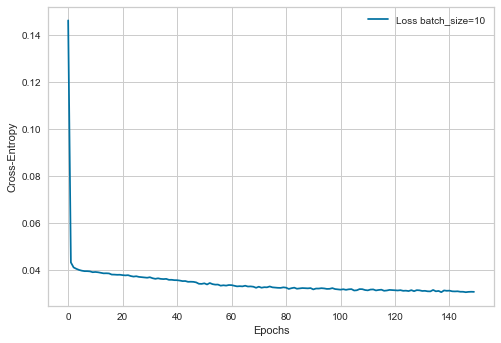

In [12]:
# ---------- ESEMPIO
# ---------- COSTRUIRE IL MODELLO
n_feature = X_train.shape[1]
model = Sequential()
model.add(Dense(12, input_dim=n_feature, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
# ---------- COMPILARE IL MODELLO
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# ---------- FITTARE IL MODELLO
# Epochs = numero fisso di iterazioni
# Batchs_size = numero di righe che vengono prese in considerazione prima che i pesi 
#               del modello vengano aggiornati all'interno di ogni epoca
# per problemi mettere "verbose=0"
history1 = model.fit(X_train, y_train, epochs=150, batch_size=10).history
# ---------- VALUTARE IL MODELLO
# uso la funzione evaluate che restituisce la loss del modello nel set di dati e l'accuratezza
# Valutazione: https://machinelearningmastery.com/evaluate-skill-deep-learning-models/
test_loss_1, test_acc_1 = model.evaluate(X_test, y_test)
print('Loss %f, Accuracy %f' % (test_loss_1, test_acc_1))
plt.plot(history1['loss'], label='Loss batch_size=10')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy')
plt.legend()
plt.show()